<a href="https://colab.research.google.com/github/whitefreeze/Pump-It-up-Pump-Failure-Prediction/blob/main/Pump_It_Up_Pump_Failure_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [Pump Failure Prediction](https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/page/23/)

Predict the status of waterpoints/pumps and catagorize into the following three categories for 'status_group':
> * 'functional'
> * 'non functional'
> * 'functional needs repair'

Submission will include the 'id' and 'status_group' features.

## Prepare Dataset

### Import Packages

In [ ]:
## Pandas
import pandas as pd
## Numpy
import numpy as np
## MatplotLib
import matplotlib.pyplot as plt
## Seaborn
import seaborn as sns

# re Python library
import re

# Matplotlib Colors
import matplotlib.colors as mcolors

## Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_selector
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer

## Classification Metrics
from sklearn import metrics
#from sklearn.metrics import accuracy_score, recall_score, precision_score, \
#f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, \
#RocCurveDisplay

# Display all columns
pd.set_option('display.max_column', None)

### Functions

**Add evaluate_regression function if needed**

In [ ]:
## Define a function that takes in arguments and prints out a classification report and confusion matrix
def evaluate_classification(model, X_train, y_train, X_test, y_test,
                            cmap='Greens', normalize=None, classes=None, 
                            figsize=(20,5), name='Classification Model', 
                            average='binary', zero_division=0):
  """Takes as required arguments: a model, traing features, training labels,
  testing feature, testing labels
  Prints a classification reports and confusion matrics for each data set
  returns a dataframe of metrics

  Optional arguments: 
    cmap: colormap 
    normalize: confusion matrix normalization ['true', 'pred', 'all' or None]
    classes: ordered list of class labels
    figsize: size of figure
    name: give your model a name
    average: how to aggregate scores for multiclass problems
    zero_division: what should the result of divide by zero be?"""

  # Gather model predictions
  train_preds = model.predict(X_train)
  test_preds = model.predict(X_test)

  # Display classification report and confusion matrices
  print('======Train Set Metrics======')
  print(metrics.classification_report(y_train, train_preds, 
                                      zero_division=0,
                                      target_names=classes))
  
  print('======Test Set Metrics======')
  print(metrics.classification_report(y_test, test_preds, 
                                      zero_division=0,
                                      target_names=classes))

  fig, axes = plt.subplots(ncols=2, figsize=figsize)

  ConfusionMatrixDisplay.from_predictions(y_train, train_preds, cmap=cmap, 
                                display_labels=classes,
                                normalize=normalize, ax=axes[0])
  axes[0].set_title('Train Confusion Matrix')

  ConfusionMatrixDisplay.from_predictions(y_test, test_preds, cmap=cmap, 
                              display_labels=classes,
                              normalize=normalize, ax=axes[1])
  axes[1].set_title('Test Confusion Matrix')
  plt.show()

  # If there are more than 2 classes and an average has not been set, 
  # set average to 'macro'
  if average == 'binary' and y_train.nunique() > 2:
    average = 'macro'

  # Create a dataframe of scores to return
  scores = pd.DataFrame()
  
  # Training

  scores.loc[name, 'Train Accuracy'] = accuracy_score(y_train, train_preds)
  scores.loc[name, 'Train Recall'] = recall_score(y_train, train_preds,
                                                           average=average,
                                                       zero_division=zero_division)
  scores.loc[name, 'Train Precision'] = precision_score(y_train, train_preds,
                                                           average=average,
                                                      zero_division=zero_division)
  scores.loc[name, 'Train F1-Score'] = f1_score(y_train, train_preds,
                                                           average=average,
                                                     zero_division=zero_division)
  
  # Testing
  scores.loc[name, 'Test Accuracy'] = accuracy_score(y_test, test_preds)
  scores.loc[name, 'Test Recall'] = recall_score(y_test, test_preds,
                                                           average=average,
                                                      zero_division=zero_division)
  scores.loc[name, 'Test Precision'] = precision_score(y_test, test_preds,
                                                           average=average,
                                                      zero_division=zero_division)
  scores.loc[name, 'Test F1-Score'] = f1_score(y_test, test_preds,
                                                           average=average,
                                                     zero_division=zero_division)

  return scores

### Source References

### Load Data

In [ ]:
# Conect to Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
## Load in Data
path = '/content/drive/MyDrive/Data Science/Coding Dojo/Course 3: ML - Advanced/Pump it Up - Data Files/training_Set_values.csv'

# skipinitialspace used to ignore spaces immediately following the delimiter
df = pd.read_csv(path, skipinitialspace=True)
df.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,True,GeoData Consultants Ltd,VWC,Roman,False,1999,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280,NaN,GeoData Consultants Ltd,Other,NaN,True,2010,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,250,True,GeoData Consultants Ltd,VWC,Nyumba ya mungu pipe scheme,True,2009,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,63,Nanyumbu,Nanyumbu,58,True,GeoData Consultants Ltd,VWC,NaN,True,1986,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,Kyanyamisa,Kagera,18,1,Karagwe,Nyakasimbi,0,True,GeoData Consultants Ltd,NaN,NaN,True,0,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


In [ ]:
# Display shape of dataset
df.shape

(59400, 40)

The dataset has 40 features.

In [ ]:
# Count number of features
shape = df.shape
print('Number of columns: ', shape[1])

Number of columns:  40


The dataset has 59,400 observations in the dataset.

In [ ]:
print(f'The "Pump It Up" Dataset has {len(df.index)} observations')

The "Pump It Up" Dataset has 59400 observations


### Data Dictionary

amount_tsh - Total static head (amount water available to waterpoint)

date_recorded - The date the row was entered

funder - Who funded the well

gps_height - Altitude of the well

installer - Organization that installed the well

longitude - GPS coordinate

latitude - GPS coordinate

wpt_name - Name of the waterpoint if there is one

num_private -

basin - Geographic water basin

subvillage - Geographic location

region - Geographic location

region_code - Geographic location (coded)

district_code - Geographic location (coded)

lga - Geographic location

ward - Geographic location

population - Population around the well

public_meeting - True/False

recorded_by - Group entering this row of data

scheme_management - Who operates the waterpoint

scheme_name - Who operates the waterpoint

permit - If the waterpoint is permitted

construction_year - Year the waterpoint was constructed

extraction_type - The kind of extraction the waterpoint uses

extraction_type_group - The kind of extraction the waterpoint uses

extraction_type_class - The kind of extraction the waterpoint uses

management - How the waterpoint is managed

management_group - How the waterpoint is managed

payment - What the water costs

payment_type - What the water costs

water_quality - The quality of the water

quality_group - The quality of the water

quantity - The quantity of water

quantity_group - The quantity of water

source - The source of the water

source_type - The source of the water

source_class - The source of the water

waterpoint_type - The kind of waterpoint

waterpoint_type_group - The kind of waterpoint


### Duplicate Observations: Identify & Address

In [ ]:
# Count number of duplicate rows in dataset
print(f'There are {df.duplicated().sum()} duplicate rows.')

There are 0 duplicate rows.


### Delete Unnecessary Columns

There are a few features that may be duplicates, but will need to perform some analysis to determine if some features are exact replicas of others, or if there are unique values between them. Some of the features that need to be analyzed to determine if they are duplicates of each other are:

1. 
> * *payment*
> * **payment_type** (visually analyzed: equivalent values: drop "**payment_type**")

2. 
> * *quantity*
> * **quantity_group** (visually analyzed: same values: drop "**quantity_group**")


In [ ]:
# Drop 'payment_type' column
df = df.drop(columns=['payment_type'])
df.head(3)

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,True,GeoData Consultants Ltd,VWC,Roman,False,1999,gravity,gravity,gravity,vwc,user-group,pay annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280,NaN,GeoData Consultants Ltd,Other,NaN,True,2010,gravity,gravity,gravity,wug,user-group,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,250,True,GeoData Consultants Ltd,VWC,Nyumba ya mungu pipe scheme,True,2009,gravity,gravity,gravity,vwc,user-group,pay per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe


In [ ]:
# Drop 'quantity_group' column
df = df.drop(columns=['quantity_group'])
df.head(3)

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,water_quality,quality_group,quantity,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,True,GeoData Consultants Ltd,VWC,Roman,False,1999,gravity,gravity,gravity,vwc,user-group,pay annually,soft,good,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280,NaN,GeoData Consultants Ltd,Other,NaN,True,2010,gravity,gravity,gravity,wug,user-group,never pay,soft,good,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,250,True,GeoData Consultants Ltd,VWC,Nyumba ya mungu pipe scheme,True,2009,gravity,gravity,gravity,vwc,user-group,pay per bucket,soft,good,enough,dam,dam,surface,communal standpipe multiple,communal standpipe


### Inconsistent Values: Check & Address (Categorical Columns)

* Check all values for each feature to ensure that there are no inconsistent values.

In [ ]:
# funder
print(f'Number of unique values in feature: {df.funder.nunique()}')

Number of unique values in feature: 1897


In [ ]:
# funder
df.funder.value_counts()[0:15]

Government Of Tanzania    9084
Danida                    3114
Hesawa                    2202
Rwssp                     1374
World Bank                1349
Kkkt                      1287
World Vision              1246
Unicef                    1057
Tasaf                      877
District Council           843
Dhv                        829
Private Individual         826
Dwsp                       811
0                          777
Norad                      765
Name: funder, dtype: int64

For 'funder' values, we can see that there are 1,897 unique values, which will be very difficult to cross check that there are no inconsistent values. 

There are 777 instances for the value "0". This appears to be what was used to indicate "None" or a missing value. 

In [ ]:
# installer
print(f'Number of unique values in feature: {df.installer.nunique()}')

Number of unique values in feature: 2145


For 'installer' (and similar to 'funder') values, we can see that there are 2,145 unique values. This will also be very difficult to cross check for inconsistent values. 

There are also 777 instances for the value "0" in 'installer'. This, again, appears to be what was used to indicate "None" or a missing value.

In [ ]:
# installer 
df.installer.value_counts()[0:50]

DWE                           17402
Government                     1825
RWE                            1206
Commu                          1060
DANIDA                         1050
KKKT                            898
Hesawa                          840
0                               777
TCRS                            707
Central government              622
CES                             610
Community                       553
DANID                           552
District Council                551
HESAWA                          539
LGA                             408
World vision                    408
WEDECO                          397
TASAF                           396
District council                392
Gover                           383
AMREF                           329
TWESA                           316
WU                              301
Dmdd                            287
ACRA                            278
World Vision                    270
SEMA                        

We can see that there are a variety of inconsistent values that include the following (a visual inspection of the dataset was also performed and added further insight into trends and typical types of inconsistent data):

> * capitalization differences
> * erroneous spacing 
> * various implimentations for the same name/abbreviation
> * various positioning of "/" in joint ventures
> * inconsistent use of periods in names/abbreviations

An example for different spelling/abbreviation usage in names can be seen in the above value_counts:

> * 1825: Government
> *  622: Central government
> *  383: Gover
> *  222: Gove
> *  162: Centr

Also:

> * 551: District Council
> * 392: District council
> * 181: Distri

There are many, many more examples in the two features 'funder' and 'installer', some more or less obvious than others. 



Plan for addressing inconsistent values in both 'funder' and 'installer' features:

* standardize usage of "/" in names
* remove all periods from names
* remove erroneous whitespace
* set all values to uppercase

This should take care of the majority of naming inconsistencies that are relatively straight forward to fix.

To alleviate variations in naming and abbreviations, more insight into the data needs to be achieved (access to a subject-matter expert would be ideal) in order to optimize any naming standardization methods developed.

#### Inconsistent Values: Clean (Uppercase)
* set all values to uppercase

##### 'funder'

In [ ]:
# View head of 'funder' to see capitalization example
df['funder'].head(10)

0                  Roman
1                Grumeti
2           Lottery Club
3                 Unicef
4            Action In A
5    Mkinga Distric Coun
6                   Dwsp
7                  Rwssp
8               Wateraid
9            Isingiro Ho
Name: funder, dtype: object

In [ ]:
# Uppercase all values in column 'funder'
df['funder'] = df['funder'].str.upper()

In [ ]:
# View head of 'funder' to verify if capitalization has been standardized
df['funder'].head(5)

0           ROMAN
1         GRUMETI
2    LOTTERY CLUB
3          UNICEF
4     ACTION IN A
Name: funder, dtype: object

##### 'installer'

In [ ]:
# View head of 'installer' to see capitalization example
df['installer'].head(10)

0           Roman
1         GRUMETI
2    World vision
3          UNICEF
4         Artisan
5             DWE
6            DWSP
7             DWE
8       Water Aid
9         Artisan
Name: installer, dtype: object

In [ ]:
# Uppercase all values in column 'installer'
df['installer'] = df['installer'].str.upper()

In [ ]:
# View head of 'installer' to verify if capitalization has been standardized
df['installer'].head(5)

0           ROMAN
1         GRUMETI
2    WORLD VISION
3          UNICEF
4         ARTISAN
Name: installer, dtype: object

#### Inconsistent Values: Clean ("/")
* standardize usage of "/" in names

In [ ]:
# Show examples of usage for "/" in values
df[df['installer'].str.contains("/", na = False)]['installer']

63               ADRA /COMMUNITY
110               ADRA/COMMUNITY
222              ADRA /COMMUNITY
274                      RWE/DWE
401               RWE/ COMMUNITY
                  ...           
59058              RCCHURCH/CEFA
59101                TASSAF/TCRS
59174        DWE/ANGLICAN CHURCH
59241            ADRA/ COMMUNITY
59331    RC CHURCH/CENTRAL GOVER
Name: installer, Length: 664, dtype: object

##### Testing Regex

Create a sample test dataframe to correctly work out regex expression. 

In [ ]:
# create test DataFrame called "test"
# initialize list of elements
data = ["ADRA /COMMUNITY"], ["ADRA/COMMUNITY"], ["ADRA /COMMUNITY"], ["RWE/DWE"], ["RWE/ COMMUNITY"], ["RCCHURCH/CEFA"], ["TASSAF/TCRS"], ["DWE/ANGLICAN CHURCH"], ["ADRA/ COMMUNITY"], ["RC CHURCH/CENTRAL GOVER"]

# Create pandas DataFreame with column name
test = pd.DataFrame(data, columns = ['installer'])

# print dataframe
test

,installer
0,ADRA /COMMUNITY
1,ADRA/COMMUNITY
2,ADRA /COMMUNITY
3,RWE/DWE
4,RWE/ COMMUNITY
5,RCCHURCH/CEFA
6,TASSAF/TCRS
7,DWE/ANGLICAN CHURCH
8,ADRA/ COMMUNITY
9,RC CHURCH/CENTRAL GOVER


In [ ]:
# Regex pattern to search for
pattern = r'(\w+\s?)(/)(\s?\w+)'
text = ""
# Variable 'm' to hold each returned occurrence of the pattern
m = re.search(pattern, text)

# Use a lambda function on test['installer'] to join the captured groups with spaces.
test['installer'].str.replace(pattern, 
                              lambda m: m.group(1)+' '+
                              m.group(2)+' '+
                              m.group(3))

<ipython-input-24-b2521e3eea79>:8: FutureWarning: The default value of regex will change from True to False in a future version.
  test['installer'].str.replace(pattern,


0            ADRA  / COMMUNITY
1             ADRA / COMMUNITY
2            ADRA  / COMMUNITY
3                    RWE / DWE
4             RWE /  COMMUNITY
5              RCCHURCH / CEFA
6                TASSAF / TCRS
7        DWE / ANGLICAN CHURCH
8            ADRA /  COMMUNITY
9    RC CHURCH / CENTRAL GOVER
Name: installer, dtype: object

In [ ]:
# Use a lambda function on df['installer'] to join the captured groups with spaces.
df['installer'].str.replace(pattern, 
                              lambda m: m.group(1)+' '+
                              m.group(2)+' '+
                              m.group(3)).filter(items = [110], axis=0)

<ipython-input-25-803d8a168d69>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df['installer'].str.replace(pattern,


110    ADRA / COMMUNITY
Name: installer, dtype: object

Using .filter at end of .str.replace showed that row 110 (that contained a "/") was indeed updated with extra spaces on each side of the forward slash. 

##### 'installer'

We will now save our DataFrame in-place for the 'installer' feature.

In [ ]:
# Use a lambda function on df['installer'] to join the captured groups with spaces and save in-place.
df['installer'] = df['installer'].str.replace(pattern, 
                              lambda m: m.group(1)+' '+
                              m.group(2)+' '+
                              m.group(3))

<ipython-input-26-1364d87969b4>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df['installer'] = df['installer'].str.replace(pattern,


In [ ]:
# Verify usage for "/" in values
df[df['installer'].str.contains(r"/", na = False)]['installer']

63               ADRA  / COMMUNITY
110               ADRA / COMMUNITY
222              ADRA  / COMMUNITY
274                      RWE / DWE
401               RWE /  COMMUNITY
                   ...            
59058              RCCHURCH / CEFA
59101                TASSAF / TCRS
59174        DWE / ANGLICAN CHURCH
59241            ADRA /  COMMUNITY
59331    RC CHURCH / CENTRAL GOVER
Name: installer, Length: 664, dtype: object

##### 'funder'

We will repeat the same cleaning on the 'funder' feature.

In [ ]:
# Show usage for "/" in 'funder' values
df[df['funder'].str.contains(r"/", na = False)]['funder']

51                          DWE/NORAD
82       SWISLAND/ MOUNT MERU FLOWERS
90                         ISF/TACARE
265      SWISLAND/ MOUNT MERU FLOWERS
274                 NORAD /GOVERNMENT
                     ...             
59058                   RCCHURCH/CEFA
59101                  TASSAF/ DANIDA
59141               WORLD VISION/ADRA
59174             DWE/ANGLICAN CHURCH
59331                 RC CHURCH/CENTR
Name: funder, Length: 756, dtype: object

In [ ]:
# Use a lambda function on df['funder'] to join the captured groups with spaces and save in-place.
df['funder'] = df['funder'].str.replace(pattern, 
                              lambda m: m.group(1)+' '+
                              m.group(2)+' '+
                              m.group(3))

<ipython-input-29-0e45eed4e3be>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df['funder'] = df['funder'].str.replace(pattern,


In [ ]:
# Verify usage for "/" in 'funder' values
df[df['funder'].str.contains(r"/", na = False)]['funder']

51                          DWE / NORAD
82       SWISLAND /  MOUNT MERU FLOWERS
90                         ISF / TACARE
265      SWISLAND /  MOUNT MERU FLOWERS
274                 NORAD  / GOVERNMENT
                      ...              
59058                   RCCHURCH / CEFA
59101                  TASSAF /  DANIDA
59141               WORLD VISION / ADRA
59174             DWE / ANGLICAN CHURCH
59331                 RC CHURCH / CENTR
Name: funder, Length: 756, dtype: object

We have cleaned both 'funder' and 'installer' in regards to forward slash usage.

And while there are now spaces on each side of the forward slash (as we wanted, in order to make further cleaning easier), there are now double/multiple spaces in our values. 

This is fine as we will address the spacing issue for both the additional spaces that we just injected, as well as the ones pre-existing in our dataset, in a future step. 

#### Inconsistent Values: Clean (Periods)
* remove all periods from names

##### Testing Regex

We will test our "." replacement feature on a test set.

In [ ]:
# create test DataFrame called "test_dot"
# initialize list of elements
data = ['OIKOS E .AFRICA'], ['DR. MATOMOLA'], ['I.E.C'], ['T. N. KARUGENDO'], ['DR. MATOMOLA'], ['OIKOS E.AFRICA'], ['NAISHU CONSTRUCTION CO. LTD']

# Create pandas DataFreame with column name
test_dot = pd.DataFrame(data, columns = ['installer'])

# print dataframe
test_dot

,installer
0,OIKOS E .AFRICA
1,DR. MATOMOLA
2,I.E.C
3,T. N. KARUGENDO
4,DR. MATOMOLA
5,OIKOS E.AFRICA
6,NAISHU CONSTRUCTION CO. LTD


In [ ]:
# Remove all periods from values in test_dot dataset
test_dot['installer'] = test_dot['installer'].str.replace(".", " ")
# Verify
test_dot

<ipython-input-32-53d0438918e6>:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  test_dot['installer'] = test_dot['installer'].str.replace(".", " ")


,installer
0,OIKOS E AFRICA
1,DR MATOMOLA
2,I E C
3,T N KARUGENDO
4,DR MATOMOLA
5,OIKOS E AFRICA
6,NAISHU CONSTRUCTION CO LTD


Code figured out. Will now apply to entire dataset.

##### 'installer'

We will update the 'installer' feature.

In [ ]:
# Verify usage for "." in values
df[df['installer'].str.contains(".", na = False)]['installer']

0               ROMAN
1             GRUMETI
2        WORLD VISION
3              UNICEF
4             ARTISAN
             ...     
59394        ML APPRO
59395             CES
59396            CEFA
59398            MUSA
59399           WORLD
Name: installer, Length: 55745, dtype: object

In [ ]:
# Remove all periods from values in 'installer'
df.installer = df['installer'].str.replace(".", " ")

<ipython-input-34-46ffa20d159e>:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df.installer = df['installer'].str.replace(".", " ")


In [ ]:
# Verify usage for "." in values
df[df['installer'].str.contains(".", na = False)]['installer']

0               ROMAN
1             GRUMETI
2        WORLD VISION
3              UNICEF
4             ARTISAN
             ...     
59394        ML APPRO
59395             CES
59396            CEFA
59398            MUSA
59399           WORLD
Name: installer, Length: 55745, dtype: object

##### 'funder'

We will update the 'funder' feature.

In [ ]:
# Verify usage for "." in values
df[df['funder'].str.contains(".", na = False)]['funder']

0                  ROMAN
1                GRUMETI
2           LOTTERY CLUB
3                 UNICEF
4            ACTION IN A
              ...       
59394         WORLD BANK
59395    GERMANY REPUBLI
59396        CEFA-NJOMBE
59398              MALEC
59399         WORLD BANK
Name: funder, Length: 55765, dtype: object

In [ ]:
# Remove all periods from values in 'funder'
df.funder = df['funder'].str.replace(".", " ")

<ipython-input-37-bff02750e76e>:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df.funder = df['funder'].str.replace(".", " ")


In [ ]:
# Verify usage for "." in values
df[df['funder'].str.contains(".", na = False)]['funder']

0                  ROMAN
1                GRUMETI
2           LOTTERY CLUB
3                 UNICEF
4            ACTION IN A
              ...       
59394         WORLD BANK
59395    GERMANY REPUBLI
59396        CEFA-NJOMBE
59398              MALEC
59399         WORLD BANK
Name: funder, Length: 55765, dtype: object

#### Inconsistent Values: Clean (Whitespace)
* remove erroneous whitespace

Note: skipinitialspace was used on loading the data, so all spaces immediately following the delimiter for all values in all features have been ignored. I believe this will be useful for this dataset.

##### 'installer'

We will update the 'installer' feature.

In [ ]:
# Remove leading and trailing whitespace in 'installer'
df['installer'] = df.installer.str.strip()

In [ ]:
# Count number of multiple spaces in values for 'installer'
df.installer.str.count('/s+').sort_values(ascending=False)

0        0.0
39572    0.0
39560    0.0
39561    0.0
39562    0.0
        ... 
59357    NaN
59366    NaN
59370    NaN
59376    NaN
59397    NaN
Name: installer, Length: 59400, dtype: float64

##### 'funder'

We will update the 'funder' feature.

In [ ]:
# Remove leading and trailing whitespace in 'funder'
df['funder'] = df.funder.str.strip()

In [ ]:
# Count number of multiple spaces in values for 'funder'
df.funder.str.count('/s+').sort_values(ascending=False)

0        0.0
39566    0.0
39555    0.0
39556    0.0
39557    0.0
        ... 
59357    NaN
59366    NaN
59370    NaN
59376    NaN
59397    NaN
Name: funder, Length: 59400, dtype: float64

* Do the space counts above include total number of spaces in each observation? Or maximum spaces in a row for each observation? Are double/multiple spaces already removed from both features?

* Is the following line of code needed? Have all of the double/multiple spaces already been removed?

In [ ]:
# Remove duplicate white spaces in all columns
df.columns = df.columns.str.replace(r'\s+', ' ', regex=True)

A [research paper](https://www.mdpi.com/2220-9964/6/10/316) has been found that can give some insight into this dataset and some of the abbreviations used in the 'funder' and 'installer' features.

### Impossible Values: Check & Address (Numerical Columns)

* Check all values for each feature to ensure that there are no inconsistent or impossible values.

* We will display the descriptive statistics for the numeric columns only for the purpose of detecting impossible values, not for finding or removing outliers (as removing outliers could lead to data leakage)

In [ ]:
# Display the descriptive statistics for the numeric columns
df.describe(include= "number")	

,id,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year
count,59400.000000,59400.000000,59400.000000,59400.000000,5.940000e+04,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000
mean,37115.131768,317.650385,668.297239,34.077427,-5.706033e+00,0.474141,15.297003,5.629747,179.909983,1300.652475
std,21453.128371,2997.574558,693.116350,6.567432,2.946019e+00,12.236230,17.587406,9.633649,471.482176,951.620547
min,0.000000,0.000000,-90.000000,0.000000,-1.164944e+01,0.000000,1.000000,0.000000,0.000000,0.000000
25%,18519.750000,0.000000,0.000000,33.090347,-8.540621e+00,0.000000,5.000000,2.000000,0.000000,0.000000
50%,37061.500000,0.000000,369.000000,34.908743,-5.021597e+00,0.000000,12.000000,3.000000,25.000000,1986.000000
75%,55656.500000,20.000000,1319.250000,37.178387,-3.326156e+00,0.000000,17.000000,5.000000,215.000000,2004.000000
max,74247.000000,350000.000000,2770.000000,40.345193,-2.000000e-08,1776.000000,99.000000,80.000000,30500.000000,2013.000000


### Missing Values: Identify & Address


#### Zero Values: Removal

Find how "null" values are expressed in this dataset and delete them so that they can be imputed in a future step.

After further inspecting this dataset {and as observed before in the section "*Inconsistent Values: Check & Address (Categorical Columns)*"} it seems that zero is the placeholder for "null" values. 

Each feature will need to be verified as to whether zero was used to indicate a "null" value.

##### SECTION XYZ

In [ ]:
# Create Text section for EACH feature to see if zero was used as a "null" value
xyz

##### 'construction_year'

'construction_year' is the only numerical feature that it is clearly does not make sense to have a minimum value of zero. All zero values for this feature should be deleted and imputed later on.

In [ ]:
# Show examples of usage for zero in values
print(list(np.where(df["construction_year"] == 0)))

[array([    4,     6,     7, ..., 59393, 59397, 59398])]


In [ ]:
# Verify value of row #4 before replacment
df['construction_year'].filter(items = [4], axis=0)

4    0
Name: construction_year, dtype: int64

In [ ]:
# Use first index from above that returned target value (0): verify NaN returned
df['construction_year'].replace(0, np.nan).filter(items = [4], axis=0)

4   NaN
Name: construction_year, dtype: float64

In [ ]:
# Remove all zero values from 'construction_year'
df['construction_year'] = df['construction_year'].replace(0, np.nan)
df['construction_year'].filter(items = [4], axis=0)

4   NaN
Name: construction_year, dtype: float64

In [ ]:
# Verify 0 replaced with NaN
print(list(np.where(df["construction_year"] == 0)))

[array([], dtype=int64)]


In 'construction_year', all "zero" values (0) have been replaced with NaN.

##### 'longitude'

In [ ]:
# Show examples of usage for zero in values
print(list(np.where(df["longitude"] == 0)))

[array([   21,    53,   168, ..., 59295, 59324, 59374])]


In [ ]:
# Verify value of row #21 before replacment
df['longitude'].filter(items = [21], axis=0)

21    0.0
Name: longitude, dtype: float64

In [ ]:
# Use first index from above that returned target value (0): verify NaN returned
df['longitude'].replace(0, np.nan).filter(items = [21], axis=0)

21   NaN
Name: longitude, dtype: float64

In [ ]:
# Remove all zero values from 'longitude'
df['longitude'] = df['longitude'].replace(0, np.nan)
df['longitude'].filter(items = [21], axis=0)

21   NaN
Name: longitude, dtype: float64

In [ ]:
# Verify 0 replaced with NaN
print(list(np.where(df["longitude"] == 0)))

[array([], dtype=int64)]


In 'longitude', all "zero" values (0) have been replaced with NaN.

##### 'latitude'

Visually inspecting dataset reveals zero is missing, but has -2.00E-08 instead of zero.

In [ ]:
# Show examples of usage for zero in values
# Visually inspecting dataset reveals zero is missing, but has -2.00E-08 instead of zero
print(list(np.where(df["latitude"] == -2.00E-08)))

[array([   21,    53,   168, ..., 59295, 59324, 59374])]


In [ ]:
# Verify value of row #21 before replacment
df['latitude'].filter(items = [21], axis=0)

21   NaN
Name: latitude, dtype: float64

In [ ]:
# Use first index from above that returned target value (-2.00E-08): verify NaN returned
df['latitude'].replace(-2.00E-08, np.nan).filter(items = [21], axis=0)

21   NaN
Name: latitude, dtype: float64

In [ ]:
# Remove all zero values from 'latitude'
df['latitude'] = df['latitude'].replace(-2.00E-08, np.nan)
df['latitude'].filter(items = [21], axis=0)

21   NaN
Name: latitude, dtype: float64

In [ ]:
# Verify -2.00E-08 replaced with NaN
print(list(np.where(df["latitude"] == -2.00E-08)))

[array([], dtype=int64)]


In 'latitude', all "zero" values (-2.00E-08) have been replaced with NaN.

In [ ]:
# Identify any missing values per feature
df.isna().sum()

id                           0
amount_tsh                   0
date_recorded                0
funder                    3635
gps_height                   0
installer                 3655
longitude                    0
latitude                     0
wpt_name                     0
num_private                  0
basin                        0
subvillage                 371
region                       0
region_code                  0
district_code                0
lga                          0
ward                         0
population                   0
public_meeting            3334
recorded_by                  0
scheme_management         3877
scheme_name              28166
permit                    3056
construction_year            0
extraction_type              0
extraction_type_group        0
extraction_type_class        0
management                   0
management_group             0
payment                      0
water_quality                0
quality_group                0
quantity

### Imputation Strategy (for Missing Values) & Justification

### Inconsistent Values: Check & Address (Categorical Columns)

### Impossible Values: Check & Address (Numerical Columns)

### Data Type: Ensure Matching Data Dictionary

## Explore Data



### Exploratory Visualization #1

#### Visualization

<ipython-input-181-9913842d29ac>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr()


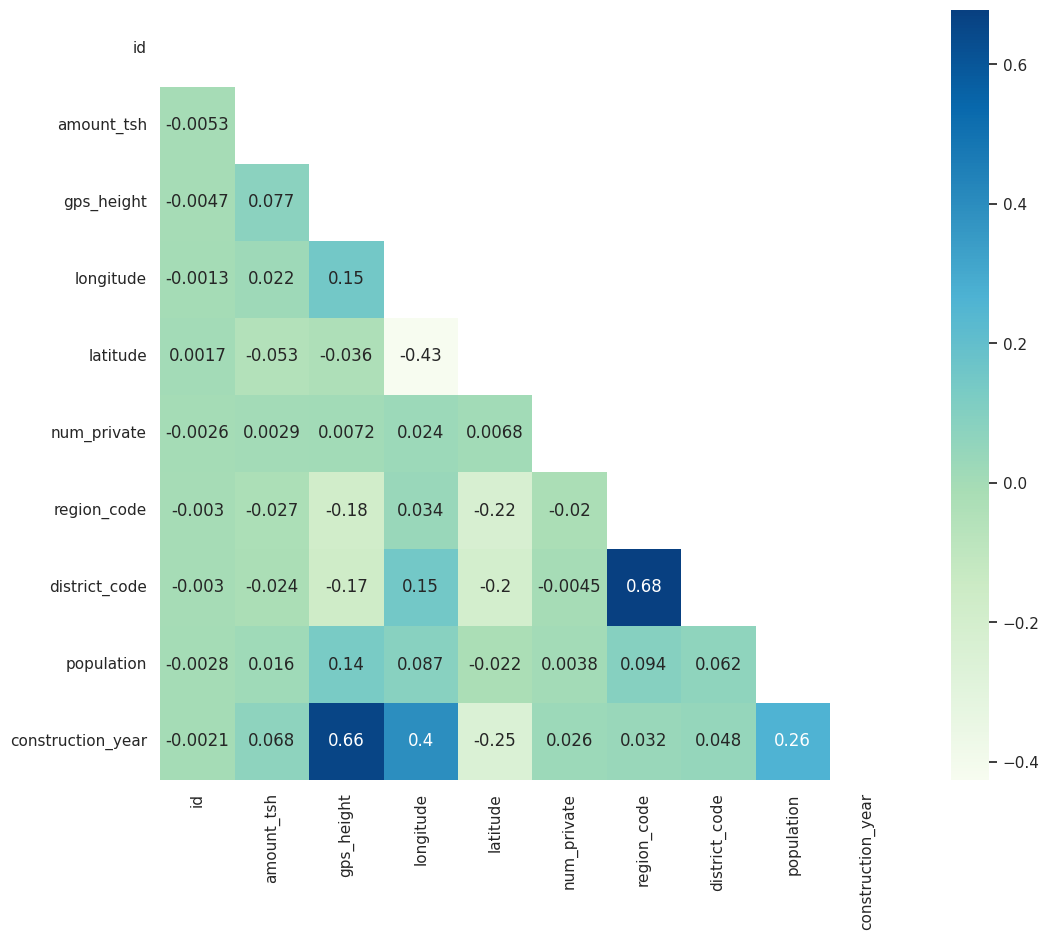

In [ ]:
# Visualization & settings
corr = df.corr()
mask = np.triu(np.ones_like(corr))
fig, ax = plt.subplots(figsize = (12,10))
ax = sns.heatmap(corr, cmap= 'GnBu', annot = True, mask = mask);

#### Explanation

There is some correlation between the following numberical features:

Very Strong, Positive (0.68): 'district_code' and 'region_code'
* This is not surprizing, as the larger part of the country will only have the same smaller parts of the country contained within itself. 

Very Strong, Positive (0.66): 'construction_year' and 'gps_height'
* While there may be a correlation between these two, I am puzzled as to what significance or useful/reliable insight this would bring.

Moderately Strong, Negative (-0.43): 'latitude' and 'longitude'
* As all of the locations are within the same, moderately-sized country, having a correlation between latitude and longitude is not surprising.

Moderately Strong, Positive (0.40): 'construction_year' and 'longitude'
* Again, I am puzzled as to how this correlation might be useful or reliable. 

There are no more correlations with a value greater than ±0.30 from zero.

### Exploratory Visualization #2

#### Visualization

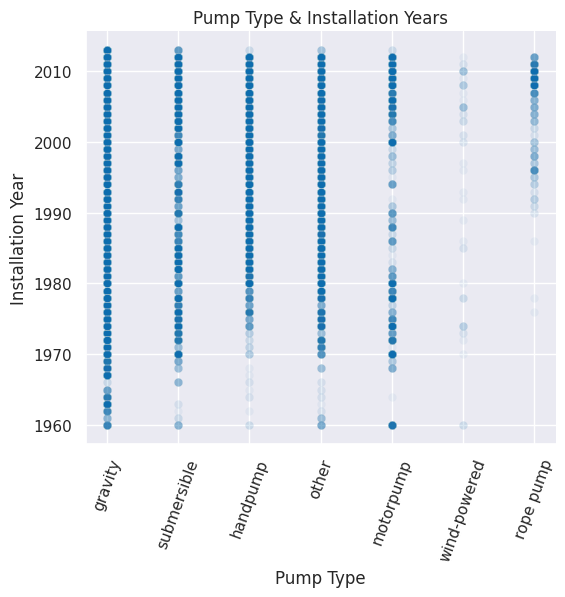

In [ ]:
# Set palette color via set_palette
sns.set_palette("GnBu_r")

# Visualization & settings
ax = sns.relplot(data=df,
                 x='extraction_type_class', y='construction_year',
                 alpha= 0.05,
                 height=5, aspect=6/5
                 )
ax.set_axis_labels('Pump Type','Installation Year')
ax.set(title='Pump Type & Installation Years')
ax.tick_params(axis='x', rotation=70);

#### Explanation

We can see that there have been many water pumps, of various types, installed in the country over the years. Some of the pumps appear to be very old, as the information goes all the way back to 1960. As people will most likely continue to need water, both the age and types of the pumps will probably big factors in determining how often servicing will be required to keep them operational.

### Exploratory Visualization #3

#### Visualization

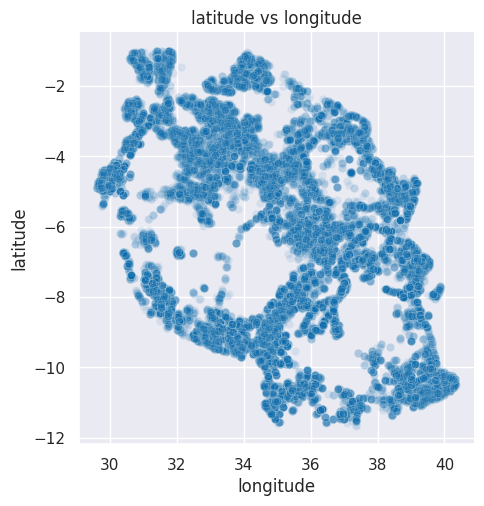

In [ ]:
ax = sns.relplot(data=df, 
                 x='longitude', y='latitude', 
                 alpha= 0.10,
                 height=5, aspect=5/5
                 )
ax.set_axis_labels('longitude','latitude')
ax.set(title='latitude vs longitude')
ax.tick_params(axis='x', rotation=0);

#### Explanation

By plotting the lattitude and longitude for each water pump in the country, we can see what resembles an outline of Tanzania! From this visualization we can see that there are pumps all over the country, and probably not just in the cities. This makes checking on each pump regularly, to see if it requires maintenace or not, a very difficult task. This would probably be a difficult undertaking for even the most advanced countries. People need access to good, clean water for their families, animals, gardens and farms. Achieving the goal of being able to predict maintence needs proactively will help reduce the amount of time people will be without access to this life-giving resource. 

### Exploratory Visualization #4

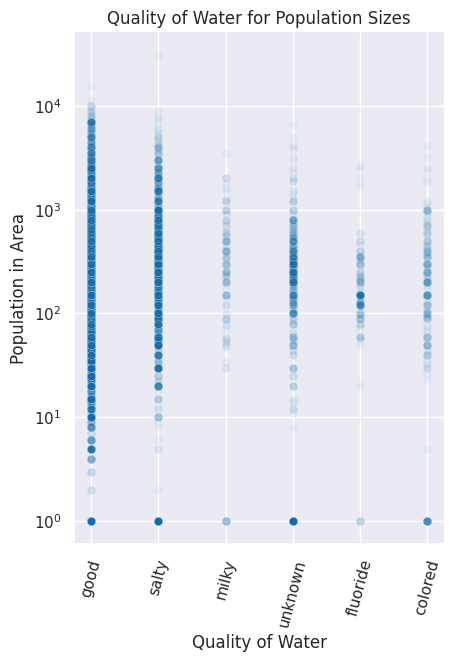

In [ ]:
# Set palette color via set_palette
sns.set_palette("GnBu_r")

# Visualization & settings
ax = sns.relplot(data=df,
                 x='quality_group', y='population',
                 alpha= 0.05,
                 height=6, aspect=5/6
                 )
ax.set(yscale="log")
ax.set_axis_labels('Quality of Water','Population in Area')
ax.set(title='Quality of Water for Population Sizes')
ax.tick_params(axis='x', rotation=75);

### Exploratory Visualization A

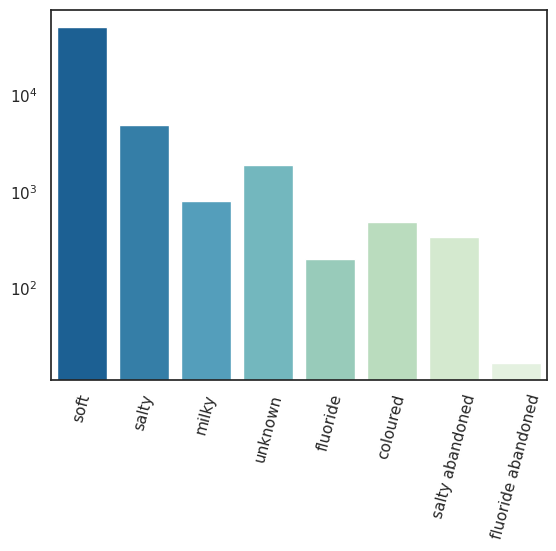

In [ ]:
# Visualization & settings
fig, ax = plt.subplots()
g = sns.countplot(data=df, x='water_quality', palette='GnBu_r')
# Set Y scale to display in logarithmic scale to account for large difference in values
g.set_yscale("log")
ax.set(xlabel='', ylabel = '')
ax.tick_params(axis='x', rotation=75)
plt.show()

### Exploratory Visualization B

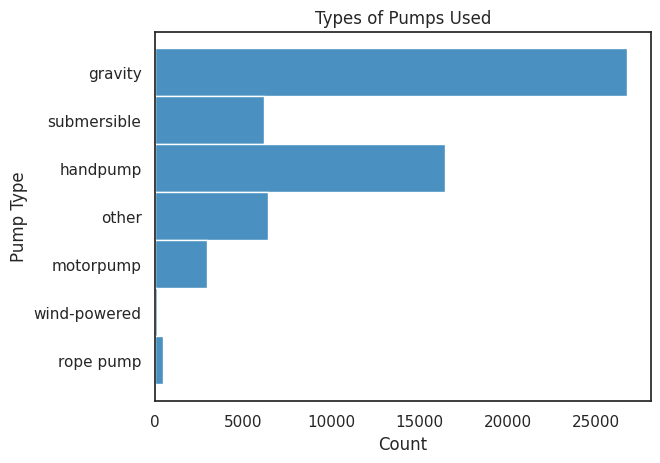

In [ ]:
# Set palette color via set_palette as .histplot does not accept palette color option without hue also being set
sns.set_palette("GnBu_r")

# Visualization & settings
fig, ax = plt.subplots()
sns.histplot(data=df, y='extraction_type_class')
ax.set_title('Types of Pumps Used')
ax.set_xlabel('Count')
ax.set_ylabel('Pump Type');

### Exploratory Visualization C

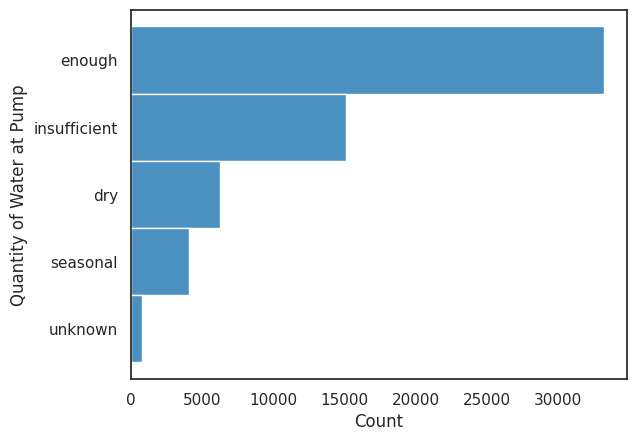

In [ ]:
# Set palette color via set_palette as .histplot does not accept palette color option without hue also being set
sns.set_palette("GnBu_r")

# Visualization & settings
fig, ax = plt.subplots()
g = sns.histplot(data=df, y='quantity')
ax.set(xlabel='Count', ylabel='Quantity of Water at Pump')
plt.show();

### Exploratory Visualization D

In [ ]:
# Sort values for 'payment' by count into a DataFrame 
payment_sorted = pd.DataFrame(df['payment'].value_counts().sort_values(ascending=False))
payment_sorted

,payment
never pay,25348
pay per bucket,8985
pay monthly,8300
unknown,8157
pay when scheme fails,3914
pay annually,3642
other,1054


In [ ]:
# Transpose DataFrame (swap columns and rows) to assist with visualization
payment_sorted_transposed = payment_sorted.T
payment_sorted_transposed

,never pay,pay per bucket,pay monthly,unknown,pay when scheme fails,pay annually,other
payment,25348,8985,8300,8157,3914,3642,1054


#### Visualization

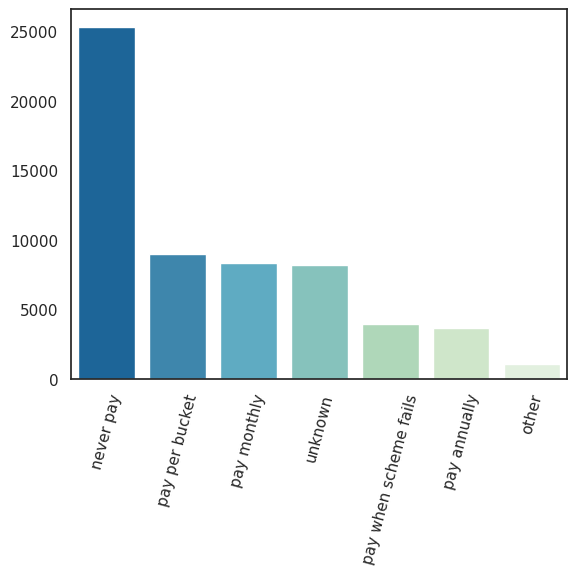

In [ ]:
# Visualization & settings
# Display values for 'payment' in order from most frequest to least frequent
fig, ax = plt.subplots()
g = sns.barplot(data=payment_sorted_transposed, palette='GnBu_r')
ax.set(xlabel='', ylabel = '')
ax.tick_params(axis='x', rotation=75)
plt.show();

### Exploratory Visualization E

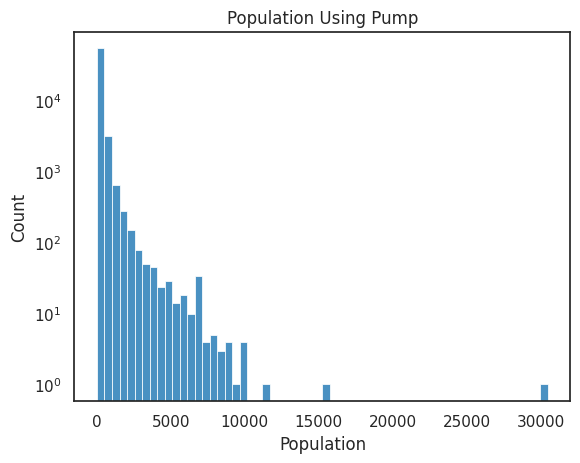

In [ ]:
# Set palette color via set_palette as .histplot does not accept palette color option without hue also being set
sns.set_palette("GnBu_r")

# Visualization & settings
fig, ax = plt.subplots()
g = sns.histplot(data=df, x='population', bins=60)
g.set_yscale("log")
ax.set_title('Population Using Pump')
ax.set_xlabel('Population')
ax.set_ylabel('Count');